In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc)

In [2]:
# Importing dataset
df = pd.read_csv('15s_Data.csv')
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1,VPN
0,14609555,14609555,14257477,41,53236,2822141,2823216,486985.166667,648067.136364,3.696211,...,6592862,6788103.0,6983344,276112.470129,1056123,1702460.0,2348797,914058.551263,VPN-FT,True
1,14997699,14976002,14976270,34,10,280324,318681,55672.869888,34036.977273,47.407272,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,STREAMING,False
2,14440454,14401292,14401395,959225,959133,960892,960909,960086.133333,960093.000000,2.215997,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
3,14441610,14402929,14403020,959367,958939,960982,961896,960195.266667,960201.333333,2.215819,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-VOIP,True
4,14993539,14993539,14778375,152,7,272001,351381,105588.302817,16365.863787,69.830078,...,-1,0.0,-1,0.000000,-1,0.0,-1,0.000000,VPN-STREAMING,True


In [3]:
# Data Preprocessing

# Remove duplicate records 
df = df.drop_duplicates()
# Removing records with missing values
df = df.dropna()

# Removing the non-numeric 'class1' column.
features = df.drop(['class1', 'VPN'], axis=1)

# Convert VPN to numeric 0 and 1
target = df['VPN'].map({True: 1, False: 0})

# Normalizing data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
# Split data into training-testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, target, test_size=0.3, random_state=42, stratify=target
)

In [ ]:
# Hyperparameter tuning 
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50,50), (100,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

mlp = MLPClassifier(
    max_iter=1000,
    random_state=42,
    # Stoping when score is not increasing
    early_stopping=True,    
    n_iter_no_change=10,    
    tol=1e-4 
)
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_mlp = grid_search.best_estimator_

print("Best parameters:", grid_search.best_params_)

Best parameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}


In [8]:
# Cross validation
scores = cross_val_score(best_mlp, X_train, y_train, cv=5, scoring='accuracy')
print("Cross Validation Scores:", scores)
average = scores.mean() * 100
print(f"Average Accuracy: {str(average)[:5]}%")

Cross Validation Scores: [0.73093639 0.72173913 0.72134387 0.70158103 0.69881423]
Average Accuracy: 71.48%


Testing Accuracy: 72.98%
              precision    recall  f1-score   support

           0       0.70      0.77      0.73      2609
           1       0.77      0.69      0.73      2814

    accuracy                           0.73      5423
   macro avg       0.73      0.73      0.73      5423
weighted avg       0.73      0.73      0.73      5423



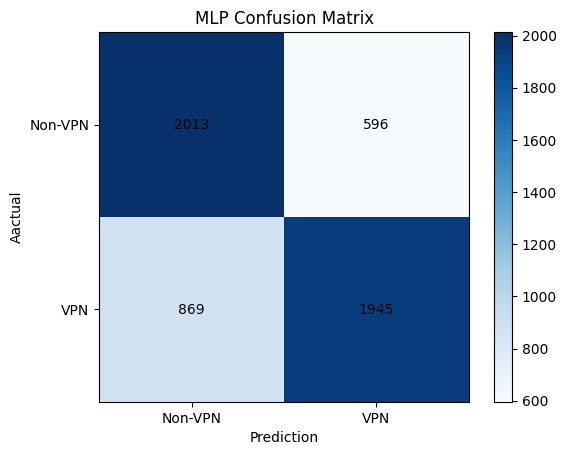

In [9]:
# Model Training and testing
best_mlp.fit(X_train, y_train)
y_pred = best_mlp.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {str(accuracy * 100)[:5]}%")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.title('MLP Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Aactual')
plt.colorbar()
plt.xticks([0, 1], ['Non-VPN', 'VPN'])
plt.yticks([0, 1], ['Non-VPN', 'VPN'])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="black")
plt.show()

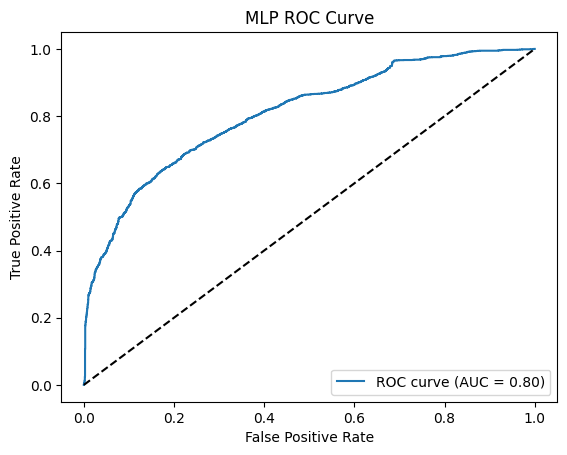

In [10]:
# Plotting ROC Curve and calculating AUC

# Getting probability estimates for the positive class.
y_prob = best_mlp.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {str(roc_auc)[:4]})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('MLP ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()
